In [6]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt

In [7]:
# Importing Data 

Housing_Data= pd.read_csv("houses_ontario.csv")


In [8]:
# Finding the length of the data set

print(len(Housing_Data))

15236


In [9]:
Housing_Data.head()


,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18


In [10]:
#Finding the null values in the data

Housing_Data.isnull().sum()

index                    0
title                    0
final_price              0
list_price               0
bedrooms                 0
bathrooms                0
sqft                     0
parking                  0
description             49
mls                      0
type                     0
full_link                0
full_address             0
lat                      0
long                     0
city_district            0
mean_district_income     0
district_code            0
dtype: int64

In [11]:
# Used Mahmoud's Cleaning function to clean the data

def cleansing_function(df):
    df = df.copy()
    abnType = df['type'].unique()[5] ## taking out the abnormal hosue type
    df = df[df['type']!= abnType]
    ## checking all the cities that are in the data

    '''
    we are going to split the data using the "," and then split based on teh space and get the city from each one,

    This will be added to a new column called "city"
    '''
    df["city"] = df["full_address"].apply(lambda x: x.split(",")[1].split(" ")[1].upper())
    ## now we will exclude the only row with the value "OUT" as city

    df = df[df["city"] != "OUT"]
    ## now let's clean the bedrooms column

    df["bedrooms"] = df["bedrooms"].apply(lambda x: ' '.join(x.split(" ")))

    for i,n in enumerate(df["bedrooms"]):
        df["bedrooms"].iloc[i] = max([int(s) for s in n.split() if s.isdigit()])
    ## now let's clean the bathrooms column

    df["bathrooms"] = df["bathrooms"].apply(lambda x: int(''.join(x.lower()).replace("baths", '')))
    ## now let's clean the parking column
    df["parking"] = df["parking"].apply(lambda x:    str(x).replace('no parking', '0')  )
    df["parking"] = df["parking"].apply(lambda x:    int(str(x).replace(' parking', '')  ))
    
    ## cleaning the type column

    df["type"] = df["type"].str.upper()

    for i,t in enumerate(df["type"]):
        if "APT" in t:
            df["type"].iloc[i] = "APT"
        elif "CONDO" in t:
            df["type"].iloc[i] = "CONDO"
        elif "DETACHED" in t:
            df["type"].iloc[i] = "DETACHED_HOUSE"
        elif "TWNHOUSE" in t:
            df["type"].iloc[i] = "TWNHOUSE"
    df["type"] = df["type"][df["type"] != "COTTAGE"][df["type"] != "FOURPLEX"]
    
    ## counting out rows that have bathrooms more than bedrooms
    df = df.query("bedrooms >= bathrooms")
    
    ## cleaning the sqft column and applying the average on each value
    sqft = df["sqft"].str.split(" ", 1).apply(lambda x: x[0])
    sqft.replace({"N/A": "0-0"}, inplace=True)
    sqft = sqft.apply(lambda x: re.split('–|-',x))

    sqft = sqft.apply(lambda x: min(int(x[0]) , int(x[1])))
    sqft.replace({0: np.nan}, inplace=True)
    df["sqft"] = sqft
    
    frames = []
    for room in list(set(df['bedrooms'])):
        df_rooms = df[df['bedrooms']== room]
        df_rooms['sqft'].fillna(df_rooms['sqft'].min(),inplace = True)
        frames.append(df_rooms)
    final_df = pd.concat(frames)
    final_df = final_df.reset_index().drop(columns=['index', 'level_0'])
    final_df["sqft"] = final_df["sqft"].round()
    df = final_df
    return df

In [12]:
Housing_Data = cleansing_function(Housing_Data)
Housing_Data.shape

C:\Users\Anchal Shukla\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\ANCHAL~1\AppData\Local\Temp/ipykernel_40936/1676093001.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sqft"] = sqft
C:\Users\Anchal Shukla\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

(13310, 18)

In [13]:
#Clean data for processing

Housing_Data.head()

,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code,city
0,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1,1,500.0,0,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,APT,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104,TORONTO
1,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1,1,600.0,1,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,APT,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82,TORONTO
2,"412 - 99 Blackwell Ave, Toronto (E4513033) | Z...",269900,269900,1,1,600.0,1,Excellent Location! Well-Kept Spacious 1 Bdrm ...,E4513033,APT,https://www.zoocasa.com/toronto-on-real-estate...,"99 Blackwell Ave, Toronto , Ontario, Canada",43.805327,-79.220229,Malvern,29573,132,TORONTO
3,"1006 - 2 Glamorgan Ave, Toronto (E4512065) | Z...",325000,299000,1,1,700.0,1,Beautiful One Bedroom Unit Is Newly Updated An...,E4512065,APT,https://www.zoocasa.com/toronto-on-real-estate...,"2 Glamorgan Ave, Toronto , Ontario, Canada",43.769495,-79.283388,Dorset Park,31692,126,TORONTO
4,"2023 - 800 Lawrence Ave W, Toronto (W4509807) ...",478000,469000,1,1,600.0,1,A Must See - Spacious 1+1 Bedroom In Near York...,W4509807,APT,https://www.zoocasa.com/toronto-on-real-estate...,"800 Lawrence Ave W, Toronto , Ontario, Canada",43.714543,-79.453072,Yorkdale-Glen Park,38527,31,TORONTO


### Find which one is most common bedrooms

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

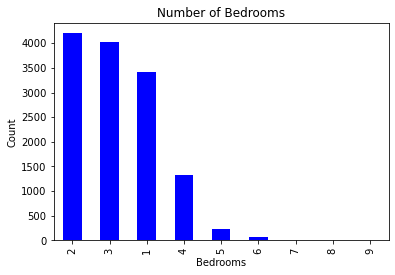

In [14]:
# Visualization to see which are most common Bedrooms

import seaborn as sns
Housing_Data['bedrooms'].value_counts().plot(kind='bar', color='b')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine


C:\Users\Anchal Shukla\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 504x504 with 0 Axes>

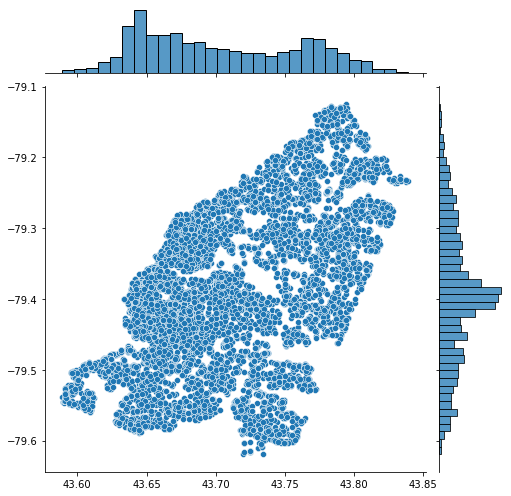

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [15]:
# Visualisation to see house availabiltiy based on the latitude and longitude

plt.figure(figsize=(7,7))
sns.jointplot(x=Housing_Data.lat.values, y=Housing_Data.long.values, size=7, kind='scatter')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
sns.despine

Text(0.5, 1.0, 'Final Price Vs. Square feet(Area)')

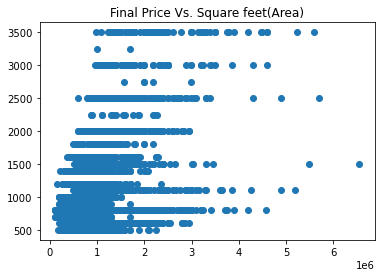

In [16]:
# Visulaization to check the relationship between finalprice and sqft

#Housing_Data.dropna(axis='columns')
New_Data= Housing_Data.dropna(subset=['sqft'])

#Housing_Data.list_price=Housing_Data.list_price.sort()
#Housing_Data.sqft=Housing_Data.sqft.sort()

plt.scatter(New_Data.list_price,New_Data.sqft)
plt.title("Final Price Vs. Square feet(Area)")

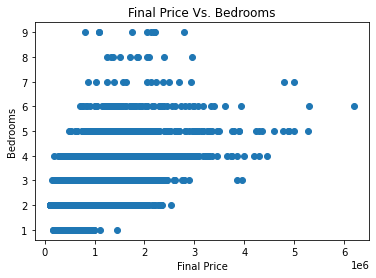

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [27]:
plt.scatter(Housing_Data.final_price, Housing_Data.bedrooms )
plt.title("Final Price Vs. Bedrooms")
plt.xlabel("Final Price")
plt.ylabel("Bedrooms")
plt.show()
sns.despine

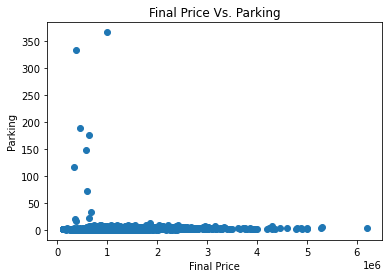

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [28]:
plt.scatter(Housing_Data.final_price, Housing_Data.parking )
plt.title("Final Price Vs. Parking")
plt.xlabel("Final Price")
plt.ylabel("Parking")
plt.show()
sns.despine

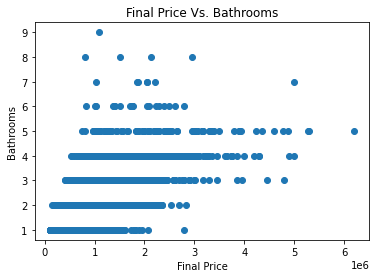

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [26]:
plt.scatter(Housing_Data.final_price, Housing_Data.bathrooms )
plt.title("Final Price Vs. Bathrooms")
plt.xlabel("Final Price")
plt.ylabel("Bathrooms")
plt.show()
sns.despine

In [18]:
#Importing Librariers for LR Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
#Features to be used to pridict price

Data_Pridiction= Housing_Data[["bedrooms", "bathrooms", "parking", "long", "lat","sqft","final_price"]]
Data_Pridiction



,bedrooms,bathrooms,parking,long,lat,sqft,final_price
0,1,1,0,-79.397498,43.708472,500.0,550000
1,1,1,1,-79.414448,43.638399,600.0,665000
2,1,1,1,-79.220229,43.805327,600.0,269900
3,1,1,1,-79.283388,43.769495,700.0,325000
4,1,1,1,-79.453072,43.714543,600.0,478000
...,...,...,...,...,...,...,...
13305,9,9,1,-79.502234,43.765282,2500.0,1080000
13306,9,8,2,-79.497067,43.768556,2000.0,810000
13307,9,5,2,-79.496027,43.766184,2500.0,1098000
13308,9,8,7,-79.439226,43.714476,2000.0,2125000


In [20]:
#Cheking the cofficent for each feature

correlation_matrix = Data_Pridiction.corr().round(2)
print(correlation_matrix)

             bathrooms  parking  long   lat  sqft  final_price
bathrooms         1.00     0.10  0.05  0.20  0.55         0.61
parking           0.10     1.00 -0.00  0.06  0.04         0.07
long              0.05    -0.00  1.00  0.47  0.00        -0.04
lat               0.20     0.06  0.47  1.00  0.11        -0.13
sqft              0.55     0.04  0.00  0.11  1.00         0.42
final_price       0.61     0.07 -0.04 -0.13  0.42         1.00


Text(0, 0.5, 'final_price')

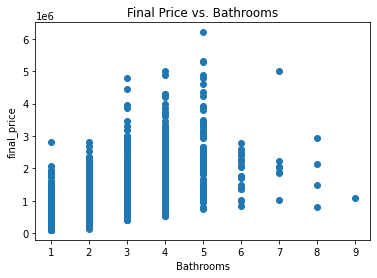

In [29]:
feature = Data_Pridiction['bathrooms']
target = Data_Pridiction['final_price']
plt.scatter(feature,target, marker='o')
plt.title('Final Price vs. Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('final_price')

In [22]:
# LinearRegression of scikit-learn
# Defining the 

x=Data_Pridiction[['bedrooms','bathrooms', 'parking','sqft', 'long', 'lat']]
y=Data_Pridiction['final_price']




In [23]:
# Splitting and Training the data, Model will be Trained by 80% data 

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.20, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(10648, 6)
(2662, 6)
(10648,)
(2662,)


In [24]:
# Running the regressor

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

LinearRegression()

ValueError: x and y must be the same size

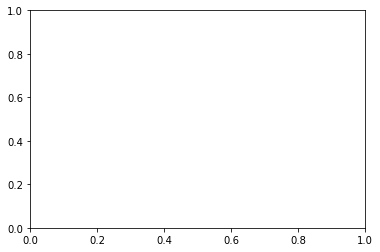

In [25]:
Y_pred = linear_model.predict(X_test)
plt.scatter(X_test, Y_test)
plt.plot(X_test, Y_pred, color ='b')
plt.title("Linear regression line for Toronto Data Set")
plt.xlabel("Bathrooms")
plt.ylabel("Final Price")

In [30]:

print(linear_model.score(X_test, Y_test))

0.4891136050250111


In [31]:
print(mean_squared_error(Y_test,Y_pred))

104532132919.47734


(10648, 1)
(2662, 1)
(10648,)
(2662,)


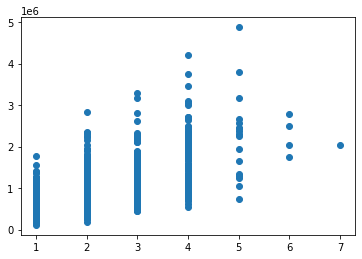

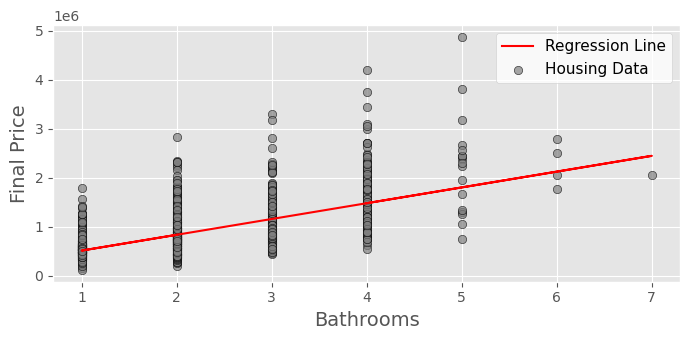

In [32]:
x=Data_Pridiction[['bathrooms']]
y=Data_Pridiction['final_price']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)


Y_pred = linear_model.predict(X_test)
plt.scatter(X_test, Y_test)


plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))

ax.plot(X_test, Y_pred, color='r', label='Regression Line')
ax.scatter(X_test, Y_test, edgecolor='k', facecolor='grey', alpha=0.7, label='Housing Data')
ax.set_ylabel('Final Price', fontsize=14)
ax.set_xlabel('Bathrooms', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
#ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()